In [2]:
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize, rotate
from numpy import random
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import image_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import os

# Please consider below pre-defined and modify according to available training dataset 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
NUM_IMAGES = 1000
NUM_DATASET_IMAGES = 790 
NUM_CLASSES = 7

seed = 42
np.random.seed = seed


In [3]:
# Initializing dataset with proper formats 
data_X = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
data_Y = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [4]:

# path to place where training images and corresponding masks are stored
# Please modify it for your training purpose if needed
DATA_PATH_X = '/content/drive/MyDrive/seep_detection/seep_detection/train_images_256'
DATA_PATH_Y = '/content/drive/MyDrive/seep_detection/seep_detection/train_masks_256'

# Fetching and Preprocessing of Input image data into proper format
for root, dir, files in os.walk(DATA_PATH_X):
  #print(root)
  #print(dir)
  for index, file in tqdm(enumerate(files)):
    img_path = DATA_PATH_X + '/' + file
    img = image_utils.load_img(img_path, color_mode = "grayscale")
    xmg = image_utils.img_to_array(img)
    # resize in case input image exceeds pre-defined image size for model training
    xmg = resize(xmg, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    data_X[index] = xmg/65535.0  # normalize

    mask_path = DATA_PATH_Y + '/' + file
    mask = image_utils.load_img(mask_path)
    mask = image_utils.img_to_array(mask) 
    # resize in case input image exceeds pre-defined image size for model training
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    data_Y[index] = mask  
    
 

790it [07:19,  1.80it/s]


In [5]:
# range of class labels in dataset
np.unique(data_Y)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [6]:
# Randomly Augmenting dataset images to increase size and diversity
# Currently, it has toal of 790 images. Need to add extra 210(70 + 70 + 70) images using 
# image rotation of randomly selected image from available dataset

# Image Augmentation function
def imageAugmentationUsingRotation(startIndex, endIndex, angle):
  for index in range(NUM_DATASET_IMAGES + startIndex, NUM_DATASET_IMAGES + endIndex):
    random_idx = random.randint(0, NUM_DATASET_IMAGES)

    image_rot = rotate(data_X[random_idx], angle, preserve_range=True).astype(np.float32)
    data_X[index] = image_rot
    
    mask_rot = rotate(data_Y[random_idx], angle, preserve_range=True).astype(np.uint8)
    data_Y[index] = mask_rot
  

# 90 degree rotation 
imageAugmentationUsingRotation(0, 70, angle=90)

# 180 degree rotation 
imageAugmentationUsingRotation(70, 140, angle=180)

# 270 degree rotation 
imageAugmentationUsingRotation(140, 210, angle=270)


In [10]:
#Shuffling and splitting total data(1000 image-mask pair) into Train and Test data with split of (90%, 10%)
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.1, random_state=seed)


In [11]:
# Understanding data distribution for each labels[0,1,2,3,4,5,6] in training dataset 
# which will affect the model training and evaluation metrics
# when ratio of class weights for each labels are very high => Highly Imbalanced data
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_Y), y = np.squeeze(train_Y).ravel())
kk = class_weights[0]
weights_tensor = tf.cast(class_weights/kk , dtype=tf.uint8)
print(weights_tensor)

tf.Tensor([  1   0 104 188  68 111  97], shape=(7,), dtype=uint8)


In [12]:
from keras.losses import categorical_crossentropy
import keras.backend as K

def weighted_categorical_crossentropy_fcn_loss(y_true, y_pred):
    # y_true is a matrix of weight-hot vectors (like 1-hot, but they have weights instead of 1s)
    y_true_mask = K.clip(y_true, 0, 1)  # [0 0 W 0] -> [0 0 1 0] where W >= 1.
    
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_mask = tf.cast(y_true_mask, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    cce = categorical_crossentropy(y_pred, y_true_mask)  # one dim less (each 1hot vector -> float number)
    y_true_weights_maxed = K.max(y_true, axis=-1)  # [0 120 0 0] -> 120 - get weight for each weight-hot vector
    wcce = cce * y_true_weights_maxed
    return K.sum(wcce)

In [26]:
# Convert classes into one-hot vector (categorical vector)
train_Y_cat = to_categorical(train_Y, num_classes= NUM_CLASSES)
test_Y_cat = to_categorical(test_Y, num_classes= NUM_CLASSES)

In [27]:
def mask2img(mask):
    palette = {
        0: (0, 0, 0),       # Black  - 0
        1: (255, 0, 0),     # Red    - 1
        2: (0, 255, 0),     # Green  - 2
        3: (0, 0, 255),     # Blue   - 3
        4: (255, 255, 0),   # Yellow - 4
        5: (255, 0, 255),   # Pink   - 5
        6: (255, 255, 255), # White  - 6
    }
    rows = mask.shape[0]
    cols = mask.shape[1]
    image = np.zeros((rows, cols, 3), dtype=np.uint8)
    for j in range(rows):
        for i in range(cols):
            image[i][j] = palette[mask[i][j]]
    return image

Text(0.5, 1.0, 'SAR-Image Mask(With Seep Label)')

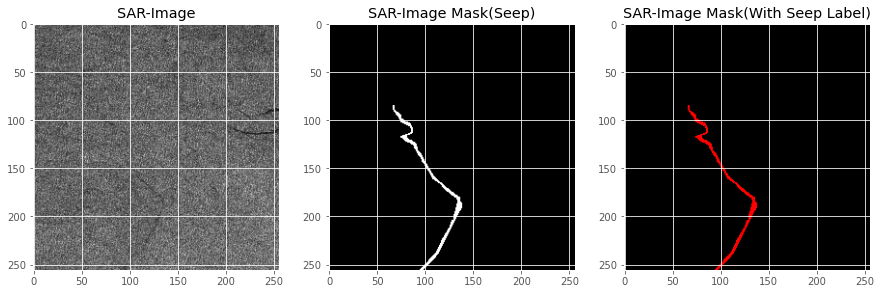

In [29]:
# Visualize any random SAR image along with the mask
idx = random.randint(0, len(train_X))
has_seep = train_Y[idx].max() > 0   # seep indicator

figure, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (15, 10))
axis1.imshow(train_X[idx, ..., 0], cmap = 'gray', interpolation = 'bilinear')
axis1.set_title('SAR-Image')

axis2.imshow(train_Y[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
axis2.set_title('SAR-Image Mask(Seep)')

axis3.imshow(mask2img(train_Y[idx].squeeze()))
axis3.set_title('SAR-Image Mask(With Seep Label)')

In [30]:
#Building Input layer
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='SAR_Image')

In [31]:
#Encoding (also called Contraction) Part
def encodingConvolutionalLayer(num_filters, input, batchNorm = True) :
  conv = keras.layers.Conv2D(filters=num_filters, kernel_size = (3,3), kernel_initializer = 'he_normal', padding='same')(input)
  if batchNorm:
    conv = keras.layers.BatchNormalization()(conv)
  conv = keras.layers.Activation('relu')(conv)
  conv = keras.layers.Conv2D(num_filters, (3,3), activation='relu', kernel_initializer = 'he_normal', padding='same')(conv)
  if batchNorm:
    conv = keras.layers.BatchNormalization()(conv)
  conv = keras.layers.Activation('relu')(conv)
  return conv

#layer 1
conv1 = encodingConvolutionalLayer(16, inputs, True)
pool1 = keras.layers.MaxPool2D((2,2))(conv1)
pool1 = keras.layers.Dropout(0.1)(pool1)

#layer 2
conv2 = encodingConvolutionalLayer(32, pool1, True)
pool2 = keras.layers.MaxPool2D((2,2))(conv2)
pool2 = keras.layers.Dropout(0.1)(pool2)

#layer 3
conv3 = encodingConvolutionalLayer(64, pool2, True)
pool3 = keras.layers.MaxPool2D((2,2))(conv3)
pool3 = keras.layers.Dropout(0.2)(pool3)

#layer 4
conv4 = encodingConvolutionalLayer(128, pool3, True)
pool4 = keras.layers.MaxPool2D((2,2))(conv4)
pool4 = keras.layers.Dropout(0.3)(pool4)

#layer 5 (bottom)
conv5 = encodingConvolutionalLayer(256, pool4, True)

#Decoding (also called Expanding) Part
def decodingConvolutionalTransposeLayer(num_filters, dropout, encodingLayer, input) :
  upLayer = keras.layers.Conv2DTranspose(num_filters, (3,3), strides=(2,2), padding='same')(input)
  upLayer = keras.layers.concatenate([upLayer, encodingLayer])  #putting pixel localization information while constructing back
  upLayer = keras.layers.Dropout(dropout)(upLayer)
  conv = encodingConvolutionalLayer(num_filters, upLayer, True)
  return conv

#layer 6
decodingLayer1 = decodingConvolutionalTransposeLayer(128, 0.3, conv4, conv5)

#layer 7
decodingLayer2 = decodingConvolutionalTransposeLayer(64, 0.2, conv3, decodingLayer1)

#layer 8
decodingLayer3 = decodingConvolutionalTransposeLayer(32, 0.1, conv2, decodingLayer2)

#layer 9
decodingLayer4 = decodingConvolutionalTransposeLayer(16, 0.1, conv1, decodingLayer3)

# output layer 
# for multi class classification, number of output class = NUM_CLASSES, activation = softmax
outputs = keras.layers.Conv2D(NUM_CLASSES, (1,1), activation='softmax')(decodingLayer4)

In [32]:
# defining model
# Used Intersection over Union (IoU) as metrics because it is pixel-based criterion
# it takes intersection of predicted and true mask  divided by union of them.
# This metrics gives more importance to how accuractly the seep part is predicted 
# rather than non-seep part which helps in measuring tight boundaries as compared to true mask
model = keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.MeanIoU(num_classes=NUM_CLASSES), 'accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 SAR_Image (InputLayer)         [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['SAR_Image[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [33]:
#Model training Monitoring functions
checkPointer = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/seep_detection/multi_model_seep_detection.h5', verbose=1, save_best_only=True, save_weights_only=True)
calbacks = [
    keras.callbacks.EarlyStopping(patience=5, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/seep_detection/logs')]


In [34]:
results = model.fit(train_X, train_Y_cat, batch_size=16, epochs=30, callbacks=calbacks, validation_data=(test_X, test_Y_cat))

Epoch 1/30
57/57 [==============================] - 18s 274ms/step - loss: 1.3720 - mean_io_u_1: 0.4286 - accuracy: 0.8118 - val_loss: 0.9545 - val_mean_io_u_1: 0.4286 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - 13s 236ms/step - loss: 0.5780 - mean_io_u_1: 0.4286 - accuracy: 0.9906 - val_loss: 0.1223 - val_mean_io_u_1: 0.4286 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 3/30
57/57 [==============================] - 13s 237ms/step - loss: 0.3074 - mean_io_u_1: 0.4286 - accuracy: 0.9915 - val_loss: 0.1807 - val_mean_io_u_1: 0.4286 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 4/30
57/57 [==============================] - 14s 241ms/step - loss: 0.1907 - mean_io_u_1: 0.4286 - accuracy: 0.9915 - val_loss: 0.1132 - val_mean_io_u_1: 0.4286 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 5/30
57/57 [==============================] - 14s 242ms/step - loss: 0.1348 - mean_io_u_1: 0.4286 - accuracy: 0.9915 - val_loss: 0.1079 - val_mean_io_u_1: 0.4286 - val_accuracy: 

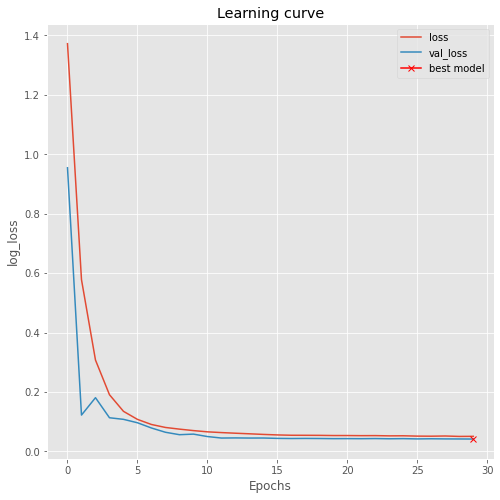

In [35]:
# Plotting Loss per epochs for model learning
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [36]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(test_X, test_Y_cat, verbose=1)

4/4 [==============================] - 2s 119ms/step - loss: 0.0416 - mean_io_u_1: 0.4286 - accuracy: 0.9940


[0.04160851985216141, 0.4285714328289032, 0.9939512610435486]

In [37]:
# Predict on train and test
preds_train = model.predict(train_X, verbose=1)
preds_test = model.predict(test_X, verbose=1)

4/4 [==============================] - 1s 101ms/step


In [38]:
# Do Threshold predictions as the predicted values are propbability values between [0, 1]
preds_train_argmax = np.argmax(preds_train, axis=3)
preds_test_argmax = np.argmax(preds_test, axis=3)

In [39]:
from keras.metrics import MeanIoU
IoU_multi = MeanIoU(num_classes=NUM_CLASSES)
IoU_multi.update_state(test_Y[:,:,:,0], preds_test_argmax)
print("Mean IoU = ", IoU_multi.result().numpy())

Mean IoU =  0.14199303


In [41]:
values = np.array(IoU_multi.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)
print(values)

[[6.513959e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [1.328800e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [7.199000e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [2.534000e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [4.887000e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [1.055600e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]
 [1.177000e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]]


In [40]:
# Plot samples along with predicted one
def plot_sample(X, y, seep_class_preds, idx=None):
    
    if idx is None:
        idx = random.randint(0, len(X))

    has_mask = y[idx].max() > 0
    print(idx)
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[idx, ..., 0], cmap='gray')
    ax[0].set_title('SAR-Image')

    ax[1].imshow(mask2img(y[idx].squeeze()))
    ax[1].set_title('SAR-Image Mask (Seep)')
    
    ax[2].imshow(mask2img(seep_class_preds[idx].squeeze()), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(seep_class_preds[idx].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Seep Predicted classes');

613


<ipython-input-40-66dfb95c2e36>:18: UserWarning: No contour levels were found within the data range.
  ax[2].contour(seep_class_preds[idx].squeeze(), colors='r', levels=[0.5])


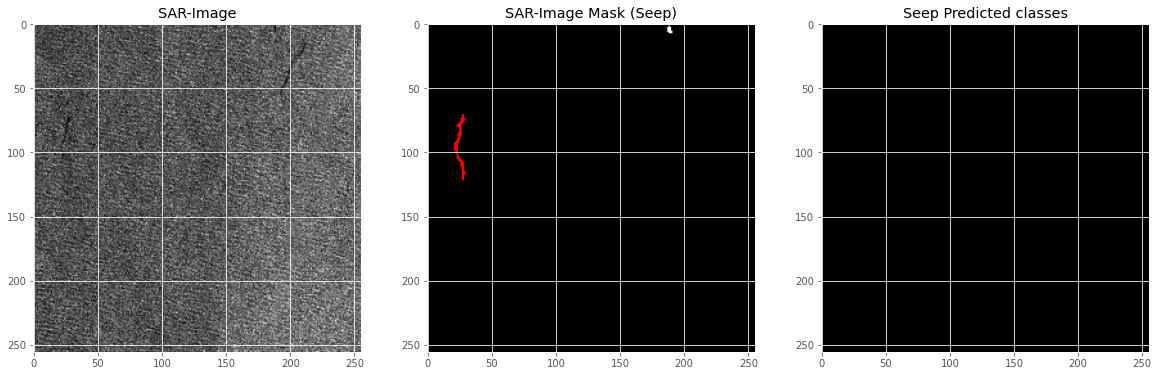

In [46]:
plot_sample(train_X, train_Y, preds_train_argmax)

In [ ]:
plot_sample(test_X, test_Y, preds_test, preds_test_argmax)

In [ ]:
import pickle


In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/seep_detection/multi_model_py', 'wb'))